# Basic Walk-Through: k-nearest Neighbors

This notebook demonstrates the machine learning workflow using a dataset of house prices and the k-nearest neighbors (KNN) algorithm. KNN can be used for both regression and classification problems.

Key points:
- KNN identifies the k nearest data points based on Euclidean distance to make predictions.
- For regression, it predicts the average outcome of the neighbors.
- For classification, it predicts the most frequent class among the neighbors.

We'll start by importing necessary libraries and loading our data from Google Drive.

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier,
                               KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score,
                                     cross_val_predict,
                                     GridSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import ValidationCurve, LearningCurve

sns.set_style('whitegrid')

In [2]:
from google.colab import drive
import pandas as pd
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set the path to your file
file_path = '/content/drive/MyDrive/ML4T/kc_house_data.csv'

# Read the CSV file
house_sales = pd.read_csv(file_path)

# Drop unnecessary columns
house_sales = house_sales.drop(['id', 'zipcode', 'lat', 'long', 'date'], axis=1)

# Display info about the dataframe
house_sales.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 2.6 MB


## Select & Transform Features

### Asset Prices often have long tails

We'll start by visualizing the distribution of house prices, which often exhibits a long-tailed distribution.

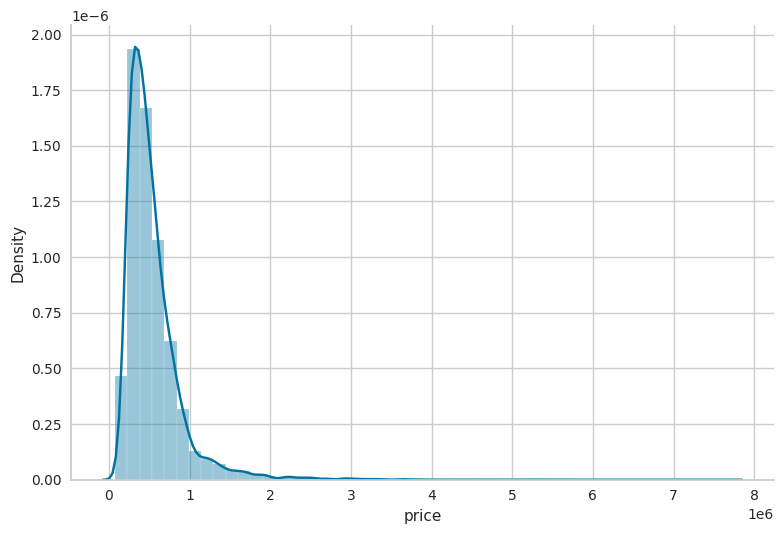

In [3]:
sns.distplot(house_sales.price)
sns.despine()
plt.tight_layout();

### Use log-transform

To deal with skewed data, we often use a log transformation. This can help to normalize the distribution of our target variable.

In [4]:
X_all = house_sales.drop('price', axis=1)
y = np.log(house_sales.price)

### Mutual information regression

We'll use mutual information to select the most informative features for our model. Mutual information measures the mutual dependence between two variables and can capture non-linear relationships.

In [5]:
mi_reg = pd.Series(mutual_info_regression(X_all, y),
                   index=X_all.columns).sort_values(ascending=False)
mi_reg

,0
sqft_living,0.347856
grade,0.344497
sqft_living15,0.269871
sqft_above,0.260815
bathrooms,0.202261
sqft_lot15,0.085216
bedrooms,0.077153
yr_built,0.075842
floors,0.074800
sqft_basement,0.070803


In [6]:
X = X_all.loc[:, mi_reg.iloc[:10].index]

### Bivariate Scatter Plots

Let's visualize the relationship between our selected features and the log-transformed price.

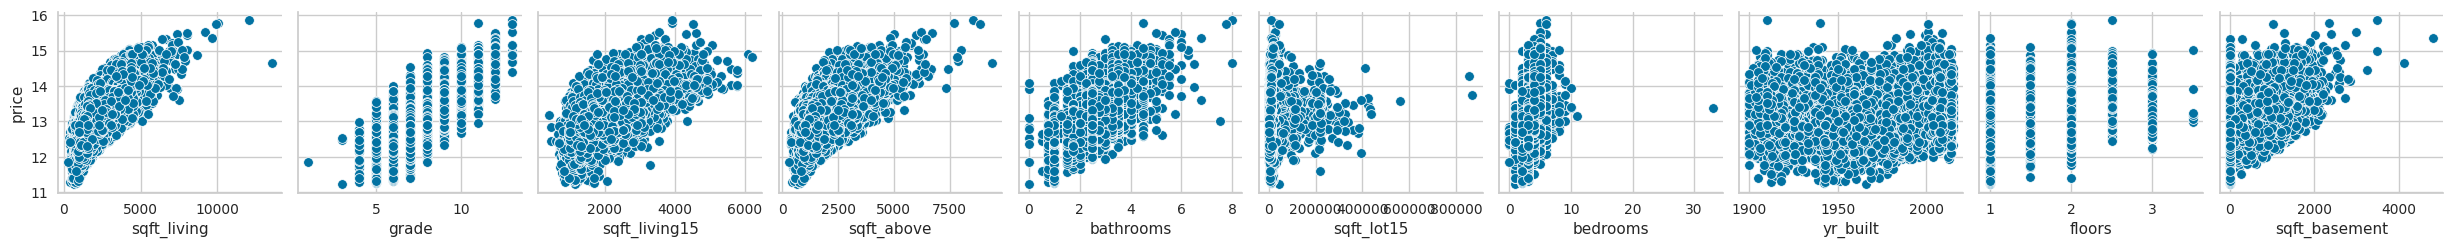

In [7]:
g = sns.pairplot(X.assign(price=y), y_vars=['price'], x_vars=X.columns)
sns.despine();

### Explore Correlations

We'll also look at the correlations between our features and the target variable.

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sqft_living    21613 non-null  int64  
 1   grade          21613 non-null  int64  
 2   sqft_living15  21613 non-null  int64  
 3   sqft_above     21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_lot15     21613 non-null  int64  
 6   bedrooms       21613 non-null  int64  
 7   yr_built       21613 non-null  int64  
 8   floors         21613 non-null  float64
 9   sqft_basement  21613 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.6 MB


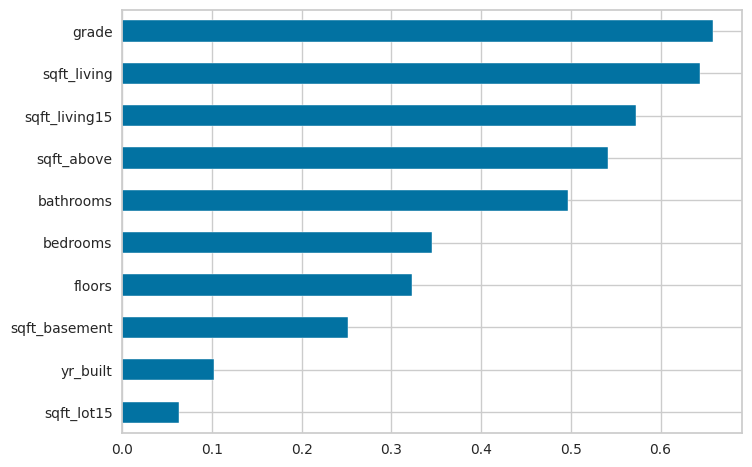

In [9]:
correl = X.apply(lambda x: spearmanr(x, y)[0])
correl.sort_values().plot.barh();

## KNN Regression

### In-sample performance with default settings

KNN uses distance to make predictions; it requires standardization of variables to avoid undue influence based on scale. We'll start by scaling our features and fitting a KNN model with default settings.

In [10]:
# Scale the features
X_scaled = scale(X)

# Initialize and fit the KNN model with default settings
model = KNeighborsRegressor()
model.fit(X=X_scaled, y=y)

# Make predictions
y_pred = model.predict(X_scaled)

### Regression Error Metrics

We'll use various metrics to evaluate our model's performance.

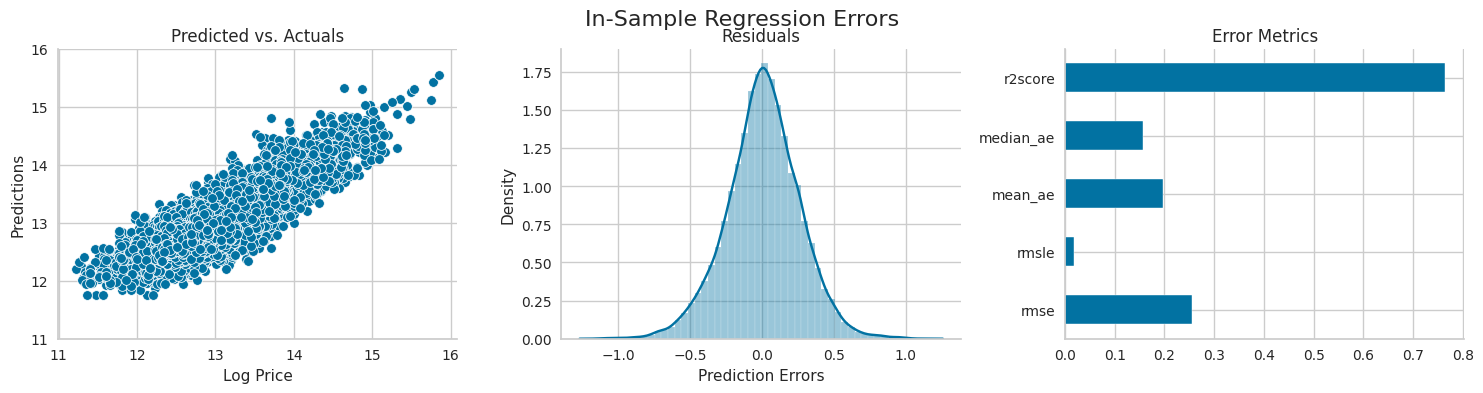

In [11]:
# Import necessary metrics
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error,
                             median_absolute_error,
                             explained_variance_score,
                             r2_score)

# Calculate prediction errors
error = (y - y_pred).rename('Prediction Errors')

# Calculate various error metrics
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)

# Visualize the results
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

# Plot predicted vs actual values
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
axes[0].set_title('Predicted vs. Actuals')

# Plot distribution of errors
sns.distplot(error, ax=axes[1])
axes[1].set_title('Residuals')

# Plot error metrics
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')

fig.suptitle('In-Sample Regression Errors', fontsize=16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.88)

### Cross-Validation

Now, we'll use cross-validation to get a more robust estimate of our model's performance. We'll also experiment with different numbers of neighbors to find the optimal value.

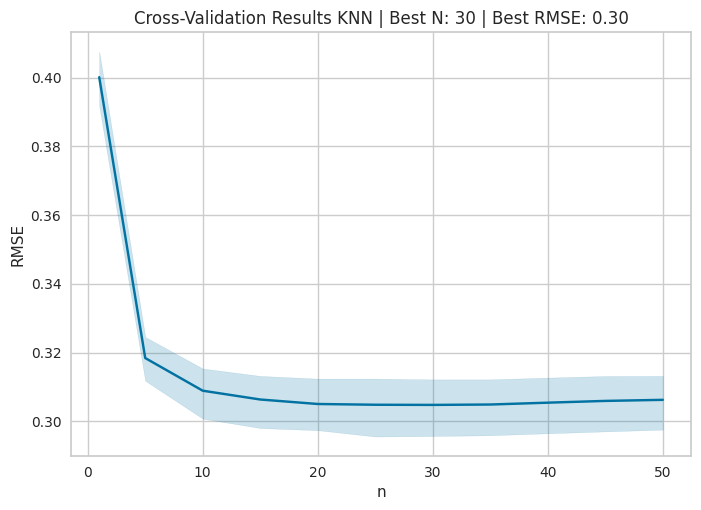

In [12]:
# Define RMSE function for scoring
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=pred))

rmse_score = make_scorer(rmse)

# Perform cross-validation for different numbers of neighbors
cv_rmse = {}
n_neighbors = [1] + list(range(5, 51, 5))
for n in n_neighbors:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsRegressor(n_neighbors=n))])
    cv_rmse[n] = cross_val_score(pipe,
                                X=X,
                                y=y,
                                scoring=rmse_score,
                                cv=5)

# Process results
cv_rmse = pd.DataFrame.from_dict(cv_rmse, orient='index')
best_n, best_rmse = cv_rmse.mean(1).idxmin(), cv_rmse.mean(1).min()
cv_rmse = cv_rmse.stack().reset_index()
cv_rmse.columns =['n', 'fold', 'RMSE']

# Plot results
ax = sns.lineplot(x='n', y='RMSE', data=cv_rmse)
ax.set_title(f'Cross-Validation Results KNN | Best N: {best_n:d} | Best RMSE: {best_rmse:.2f}');

#### Actuals vs Predicted

Let's visualize how well our best model predicts the actual prices.

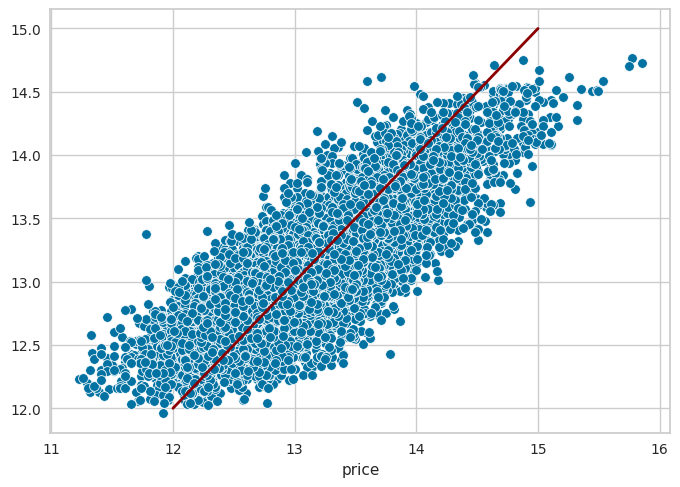

In [13]:
# Create pipeline with best number of neighbors
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor(n_neighbors=best_n))])

# Perform cross-validated predictions
y_pred = cross_val_predict(pipe, X, y, cv=5)

# Plot actual vs predicted values
ax = sns.scatterplot(x=y, y=y_pred)
y_range = list(range(int(y.min() + 1), int(y.max() + 1)))
pd.Series(y_range, index=y_range).plot(ax=ax, lw=2, c='darkred');

#### Cross-Validation Errors

After performing cross-validation, we'll analyze the errors in more detail.

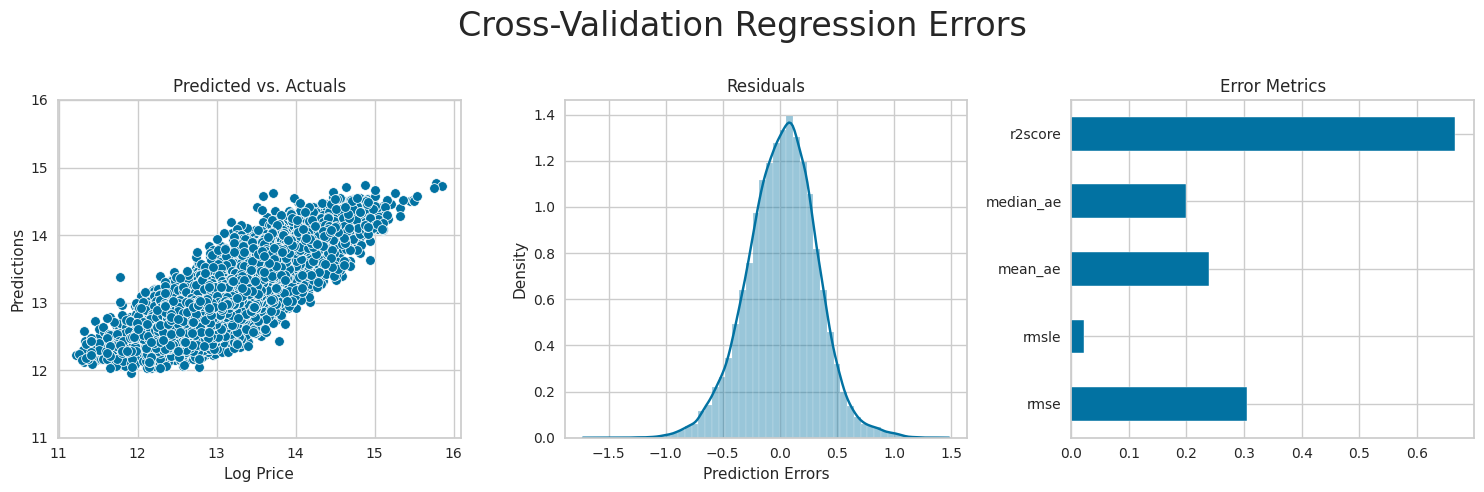

In [14]:
# Calculate prediction errors
error = (y - y_pred).rename('Prediction Errors')

# Calculate various error metrics
scores = dict(
    rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
    rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
    mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
    median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
    r2score=explained_variance_score(y_true=y, y_pred=y_pred)
)

# Create plots
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

# Plot predicted vs actual values
sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
axes[0].set_title('Predicted vs. Actuals')

# Plot distribution of errors
sns.distplot(error, ax=axes[1])
axes[1].set_title('Residuals')

# Plot error metrics
pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')

fig.suptitle('Cross-Validation Regression Errors', fontsize=24)
fig.tight_layout()
plt.subplots_adjust(top=.8);

### GridSearchCV with Pipeline

We'll now use GridSearchCV to perform an exhaustive search over specified parameter values for our KNN model. We'll use a pipeline to ensure proper scaling of our features.

In [16]:
# Create a pipeline that scales the features and then applies KNN
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor())])

# Set up the cross-validation
n_folds = 5
# Define the range of neighbors to try
n_neighbors = tuple(range(5, 101, 5))

# Define the parameter grid
param_grid = {'knn__n_neighbors': n_neighbors}

# Set up GridSearchCV
estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=rmse_score)

# Fit the model
estimator.fit(X=X, y=y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': (5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100)},
             scoring=make_scorer(rmse))

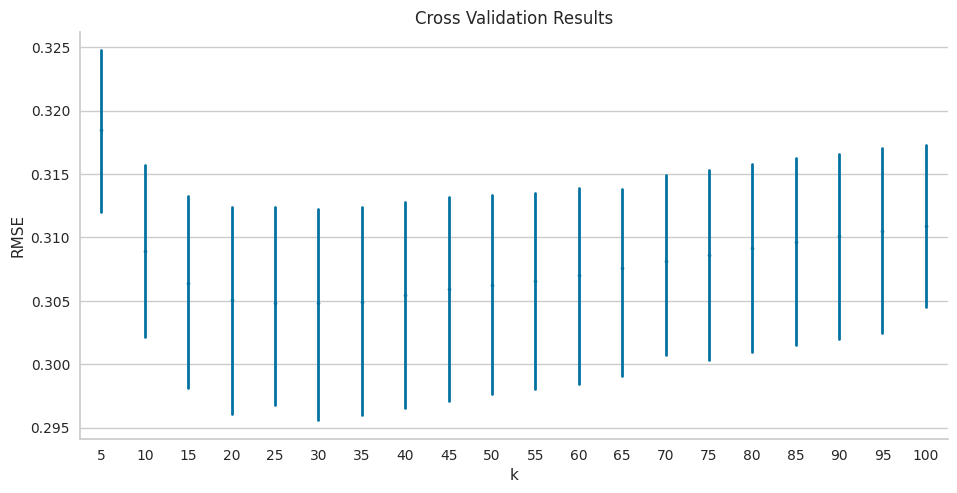

In [15]:


# Extract the cross-validation results
cv_results = estimator.cv_results_

# Prepare the results for plotting
test_scores = pd.DataFrame({fold: cv_results[f'split{fold}_test_score'] for fold in range(n_folds)},
                           index=n_neighbors).stack().reset_index()
test_scores.columns = ['k', 'fold', 'RMSE']

# Calculate mean RMSE for each k
mean_rmse = test_scores.groupby('k').RMSE.mean()
best_k, best_score = mean_rmse.idxmin(), mean_rmse.min()

# Plot the results
sns.pointplot(x='k', y='RMSE', data=test_scores, scale=.3, join=False, errwidth=2)
plt.title('Cross Validation Results')
sns.despine()
plt.tight_layout()
plt.gcf().set_size_inches(10, 5);

### Train & Validation Curves with yellowbricks

We'll now use the yellowbrick library to visualize the validation curve and learning curve for our KNN model.

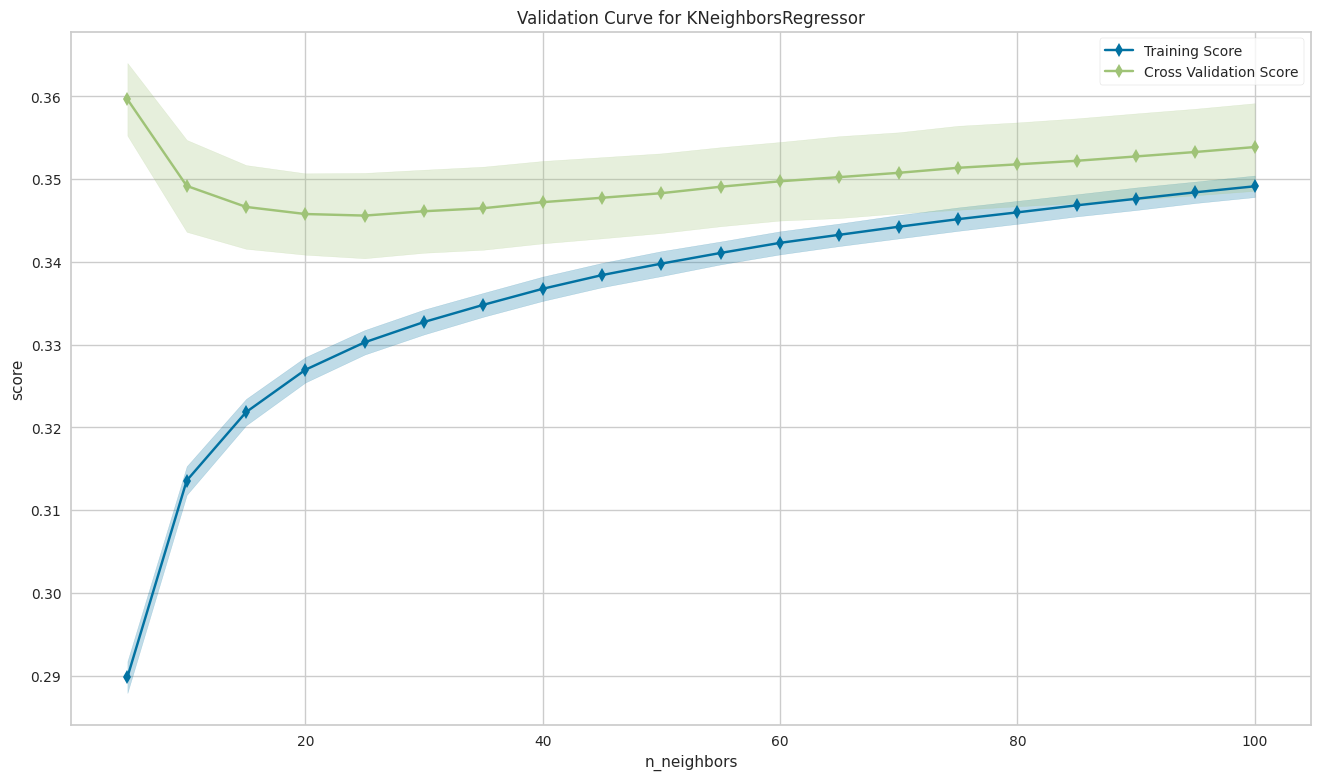

<Figure size 800x550 with 0 Axes>

In [17]:
# Create validation curve
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsRegressor(),
                      param_name='n_neighbors',
                      param_range=n_neighbors,
                      cv=5,
                      scoring=rmse_score,
                      ax=ax)
val_curve.fit(X, y)
val_curve.poof()
sns.despine()
fig.tight_layout();



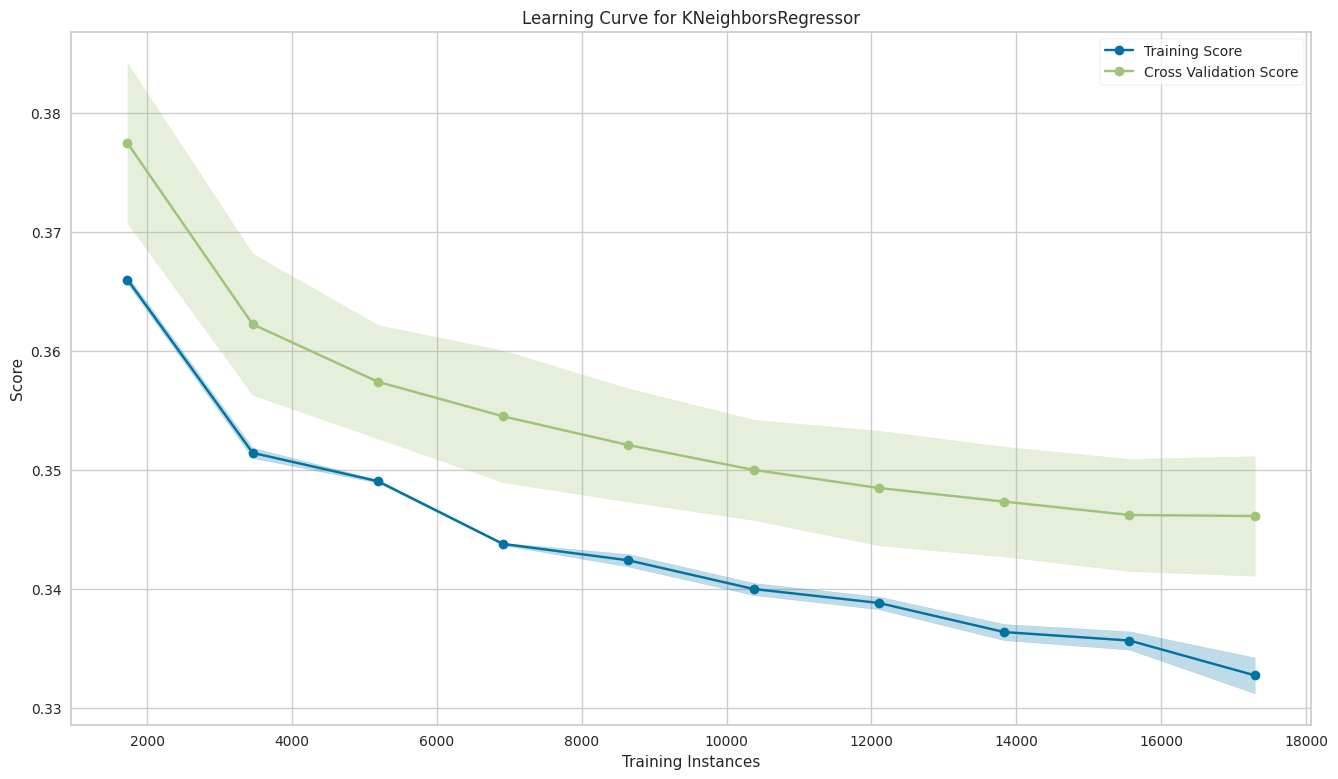

<Figure size 800x550 with 0 Axes>

In [18]:
# Create learning curve
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsRegressor(n_neighbors=best_k),
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring=rmse_score,
                        cv=5,
                        ax=ax)
l_curve.fit(X, y)
l_curve.poof()
sns.despine()
fig.tight_layout();

## Binary Classification

Now, we'll switch gears and use KNN for a binary classification task. We'll create a binary target based on whether the house price is above or below the median.

In [19]:
# Create binary target
y_binary = (y > y.median()).astype(int)

# Set up parameters for grid search
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'roc_auc'

# Create pipeline
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

# Perform grid search
estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=scoring)
estimator.fit(X=X, y=y_binary)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)},
             scoring='roc_auc')

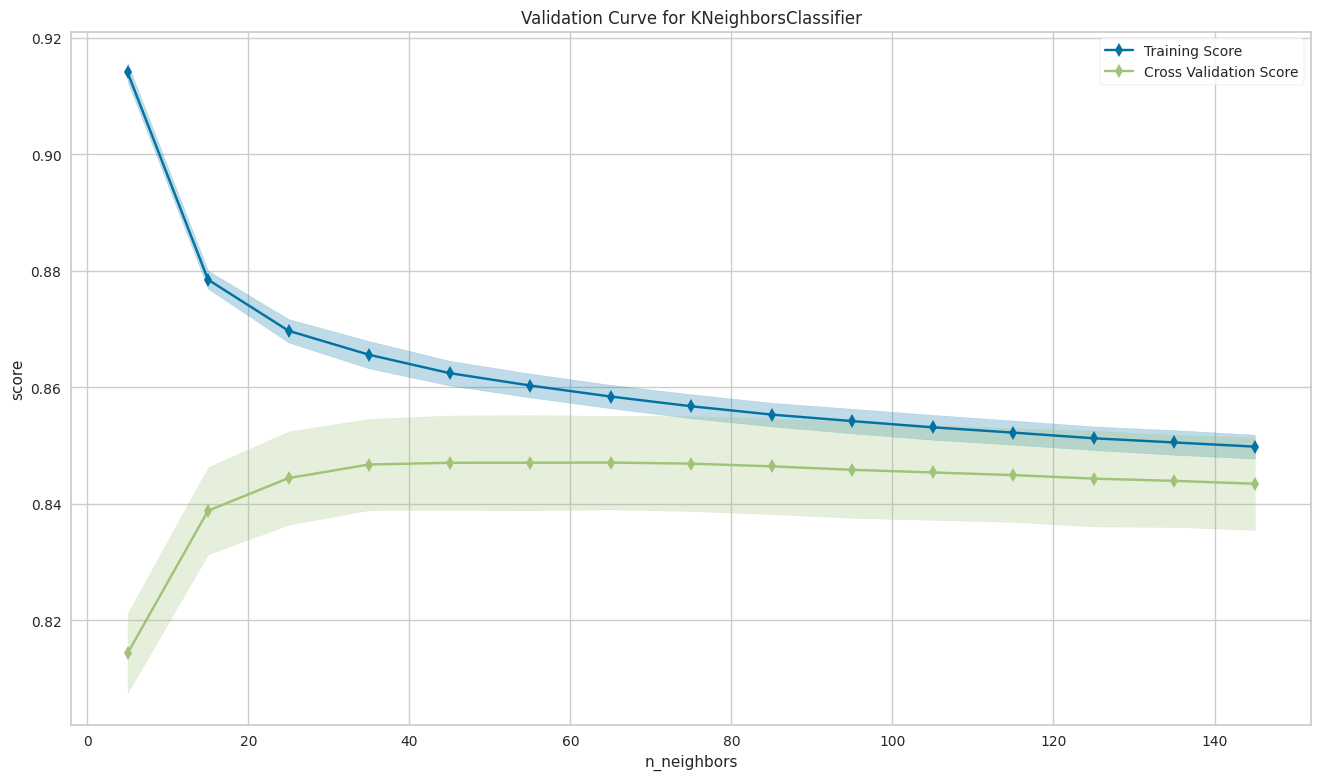

<Figure size 800x550 with 0 Axes>

In [20]:
# Get best parameters
best_k = estimator.best_params_['knn__n_neighbors']

# Create validation curve
fig, ax = plt.subplots(figsize=(16, 9))
val_curve = ValidationCurve(KNeighborsClassifier(),
                      param_name='n_neighbors',
                      param_range=n_neighbors,
                      cv=n_folds,
                      scoring=scoring,
                      ax=ax)
val_curve.fit(X, y_binary)
val_curve.poof()
sns.despine()
fig.tight_layout();

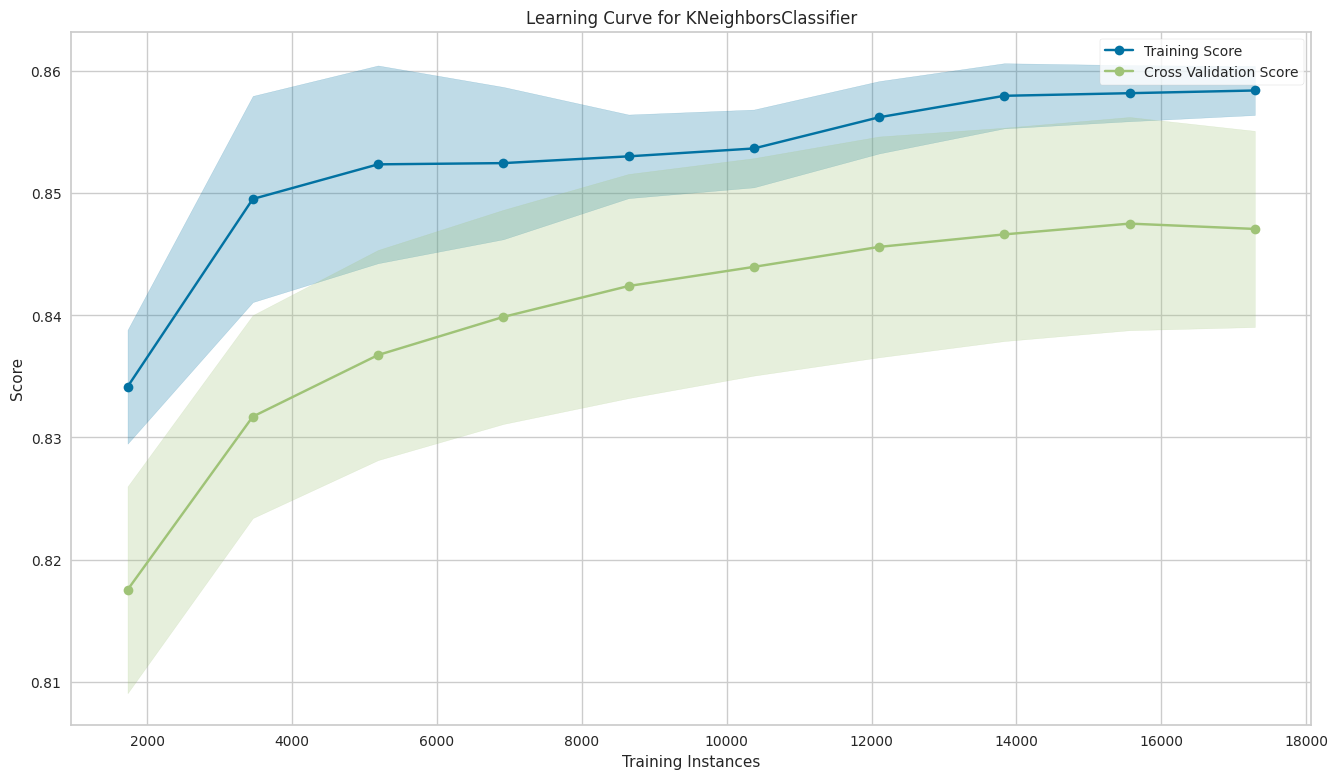

<Figure size 800x550 with 0 Axes>

In [21]:
# Create learning curve
fig, ax = plt.subplots(figsize=(16, 9))
l_curve = LearningCurve(KNeighborsClassifier(n_neighbors=best_k),
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring=scoring,
                        cv=5,
                        ax=ax)
l_curve.fit(X, y_binary)
l_curve.poof()
sns.despine()
fig.tight_layout();

### Classification Metrics

Now that we've trained our binary classification model, let's evaluate its performance using various classification metrics.

ROC AUC: 0.8460220757597617


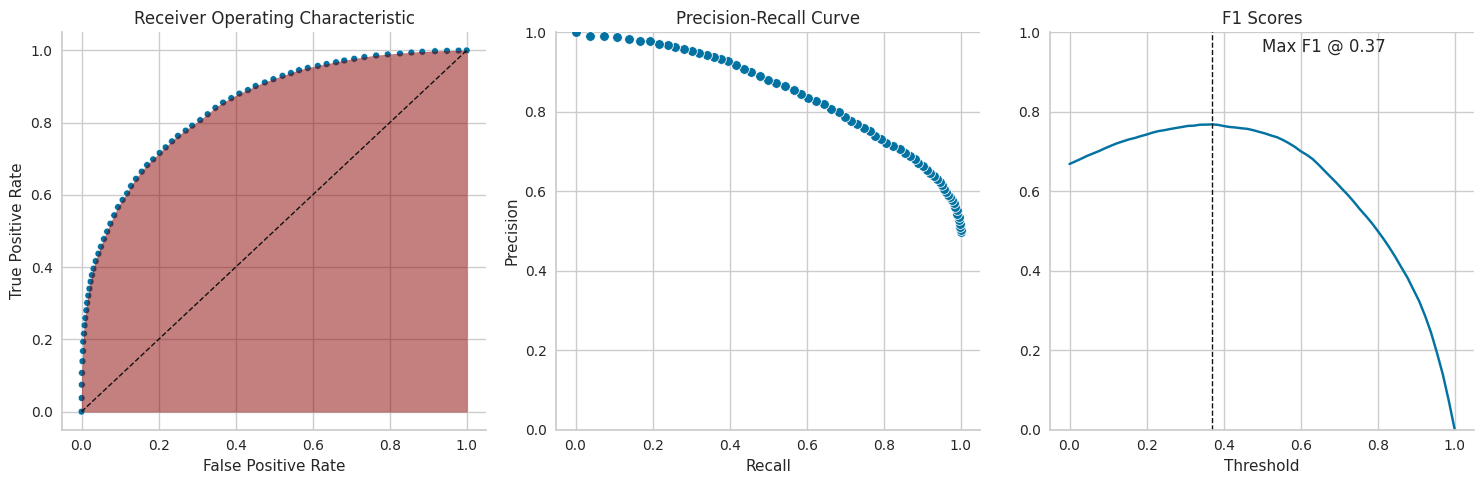

In [23]:
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             zero_one_loss,
                             roc_auc_score,
                             roc_curve,
                             brier_score_loss,
                             cohen_kappa_score,
                             confusion_matrix,
                             fbeta_score,
                             hamming_loss,
                             hinge_loss,
                             jaccard_score,
                             log_loss,
                             matthews_corrcoef,
                             f1_score,
                             average_precision_score,
                             precision_recall_curve)

# Perform cross-validated predictions
y_score = cross_val_predict(KNeighborsClassifier(best_k),
                           X=X,
                           y=y_binary,
                           cv=5,
                           n_jobs=-1,
                           method='predict_proba')[:, 1]

# Calculate prediction errors
pred_scores = dict(y_true=y_binary,y_score=y_score)

# ROC AUC
print("ROC AUC:", roc_auc_score(**pred_scores))

# ROC Curve
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

# Precision-Recall Curve
precision, recall, ts = precision_recall_curve(y_true=y_binary, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision': precision, 'Recall': recall})

# F1 Score - Optimize Threshold
f1 = pd.Series({t: f1_score(y_true=y_binary, y_pred=y_score>t) for t in ts})
best_threshold = f1.idxmax()

# Plot
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

# ROC Curve
sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, size=5, legend=False, ax=axes[0])
axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.5,color='darkred')
axes[0].set_title('Receiver Operating Characteristic')

# Precision-Recall Curve
sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')

# F1 Scores
f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
axes[2].text(s=f'Max F1 @ {best_threshold:.2f}', x=.5, y=.95)

sns.despine()
fig.tight_layout();

#### Use Predictions after thresholding

Now let's use the predictions after applying the optimal threshold we found.

In [24]:
y_pred = y_score > best_threshold
scores = dict(y_true=y_binary, y_pred=y_pred)

# F-beta Score
print("F1 Score:", fbeta_score(**scores, beta=1))

# Classification Report
print(classification_report(**scores))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(**scores))

# Accuracy
print("Accuracy:", accuracy_score(**scores))

# Zero-One Loss
print("Zero-One Loss:", zero_one_loss(**scores))

# Hamming Loss
print("Hamming Loss:", hamming_loss(**scores))

# Cohen's Kappa
print("Cohen's Kappa:", cohen_kappa_score(y1=y_binary, y2=y_pred))

# Hinge Loss
print("Hinge Loss:", hinge_loss(y_true=y_binary, pred_decision=y_pred))

# Jaccard Similarity
print("Jaccard Similarity:", jaccard_score(**scores))

# Log Loss
print("Log Loss:", log_loss(**scores))

# Matthews Correlation Coefficient
print("Matthews Correlation Coefficient:", matthews_corrcoef(**scores))

F1 Score: 0.7683696060821253
              precision    recall  f1-score   support

           0       0.82      0.63      0.71     10864
           1       0.70      0.86      0.77     10749

    accuracy                           0.74     21613
   macro avg       0.76      0.74      0.74     21613
weighted avg       0.76      0.74      0.74     21613

Confusion Matrix:
[[6871 3993]
 [1552 9197]]
Accuracy: 0.7434414472771017
Zero-One Loss: 0.2565585527228983
Hamming Loss: 0.25655855272289824
Cohen's Kappa: 0.4874843729009637
Hinge Loss: 0.759218988571693
Jaccard Similarity: 0.6238637905304572
Log Loss: 9.247307548357682
Matthews Correlation Coefficient: 0.500386387346984


## Multi-Class

Finally, let's extend our classification to a multi-class problem.

In [25]:
y_multi = pd.qcut(y, q=3, labels=[0,1,2])

n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'accuracy'

pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         n_jobs=-1)
estimator.fit(X=X, y=y_multi)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)})

In [26]:
y_pred = cross_val_predict(estimator.best_estimator_,
                           X=X,
                           y=y_multi,
                           cv=5,
                           n_jobs=-1,
                           method='predict')

print(classification_report(y_true=y_multi, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      7226
           1       0.52      0.52      0.52      7223
           2       0.77      0.74      0.75      7164

    accuracy                           0.65     21613
   macro avg       0.65      0.65      0.65     21613
weighted avg       0.65      0.65      0.65     21613

